Calculating 150000 samples...
Using 8 CPU cores


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.3s finished



Result:
slope: -0.110749
Correlation length: 9.03


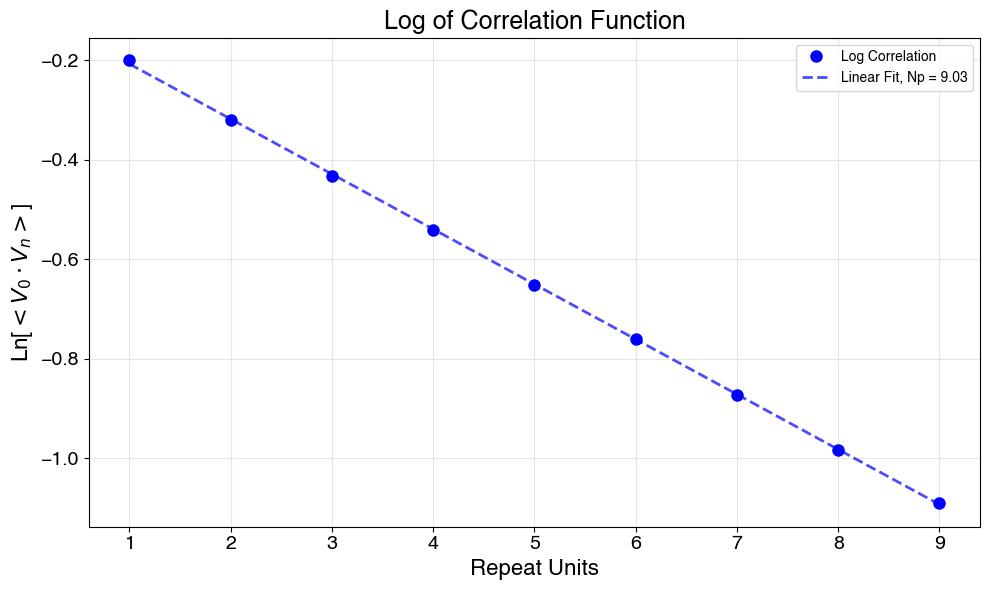

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
import matplotlib.pyplot as plt
import scipy.constants as sc
from pathlib import Path
import psutil
from joblib import Parallel, delayed

# Import the Cython module (after compilation)
import chain_rotation

# [Previous code remains unchanged, from temperature to plot_dihedral_potentials function]
temperature = 300  # K
kTval = sc.R * temperature / 1000  # kJ/mol
n_repeat_units = 20
n_samples = 150000

l = [2.533, 1.432, 3.533, 1.432, 2.533, 1.432, 2.533, 1.433, 1.363, 1.433, 2.533, 1.432]
Angle = np.deg2rad(np.array([-14.92, -10.83, 30.79, -30.79, 10.83, 14.92, -14.91, -13.29, -53.16, 53.16, 13.29, 14.91]))
rotation = np.array([0, 1, 0, 1, 0, 2, 0, 3, 0, 3, 0, 2])
labels = {
    1: {'label': 'T-DPP', 'color': 'b'},
    2: {'label': 'T-T', 'color': 'm'},
    3: {'label': 'T-E', 'color': 'c'},
}

def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    if data[:, 0].max() - data[:, 0].min() != 360:
        mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
        combined = np.vstack((data, mirrored))
        combined = np.unique(combined, axis=0)
        return combined[np.argsort(combined[:, 0])]
    else:
        return data[np.argsort(data[:, 0])]

def setup_interpolation(data_label):
    data = read_data(Path(f"{data_label['label']}.txt"))
    fitf = interp1d(data[:, 0], data[:, 1], kind='cubic', fill_value="extrapolate")
    norm_val, _ = quad(lambda x: np.exp(-fitf(x) / kTval), 0, 360)
    x_values = np.linspace(0, 360, 1000)
    prob_vals = np.exp(-fitf(x_values) / kTval) / norm_val
    cum_dist = cumulative_trapezoid(prob_vals, x_values, initial=0)
    norm_cdf = cum_dist / cum_dist[-1]
    unique_cdf_vals, unique_indices = np.unique(norm_cdf, return_index=True)
    corresponding_x_vals = x_values[unique_indices]
    inv_cdf = interp1d(unique_cdf_vals, corresponding_x_vals, 
                       kind='cubic', fill_value="extrapolate")
    return {
        'data': data, 'fitf': fitf, 'prob_vals': prob_vals,
        'inv_cdf': inv_cdf, 'x_values': x_values, 'cum_dist': cum_dist
    }

all_data = {}
for key, label_info in labels.items():
    all_data[key] = {**setup_interpolation(label_info), **label_info}

length = len(l)

def chain(n):
    l_array = np.tile(l, n)
    all_l = np.vstack((l_array, np.zeros((2, l_array.shape[0])))).T
    all_angle = np.tile(Angle, n)
    angles = np.cumsum(all_angle[1:])
    vectors = all_l[1:]
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2]
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))
    return np.cumsum(np.vstack((np.array([[0, 0, 0], [l[0], 0, 0]]), segments)), axis=0)

def pre_generate_angles(n_samples, flat_rotation, all_data):
    angles_per_position = np.zeros((n_samples, len(flat_rotation)))
    for rot_type, data_type in all_data.items():
        mask = flat_rotation == rot_type
        if np.any(mask):
            inv_cdf = data_type['inv_cdf']
            rand_vals = np.random.rand(n_samples, mask.sum())
            angles_per_position[:, mask] = inv_cdf(rand_vals)
    return angles_per_position

# === Cython optimized version ===
def batch_cosVals_optimized(ch, all_angles, flat_rotation, length):
    """Batch processing function optimized with Cython"""
    return chain_rotation.batch_cosVals_cython(
        np.ascontiguousarray(ch, dtype=np.float64),
        np.ascontiguousarray(all_angles, dtype=np.float64),
        np.ascontiguousarray(flat_rotation, dtype=np.int64),
        length
    )

# Main calculation process
ch = chain(n_repeat_units)
flat_rotation = np.concatenate([[0], rotation[np.arange(len(ch) - 1) % length]])[:-1].astype(np.int64)
all_angles = pre_generate_angles(n_samples, flat_rotation, all_data)

print(f"Calculating {n_samples} samples...")
print(f"Using {psutil.cpu_count(logical=False)} CPU cores")

# Parallel computation using Cython optimized version
batch_size = 1000
n_batches = n_samples // batch_size
n_jobs = psutil.cpu_count(logical=False)

cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(
    delayed(batch_cosVals_optimized)(
        ch, 
        all_angles[i * batch_size:(i + 1) * batch_size], 
        flat_rotation,
        length
    ) for i in range(n_batches)
)
cosList2 = np.vstack(cosList2)

# Calculate correlation length
corr2 = np.mean(cosList2, axis=0)
repeat_units = np.arange(len(corr2))
start_idx = 1
end_idx = 10

p = np.polynomial.polynomial.polyfit(
    repeat_units[start_idx:end_idx], 
    np.log(corr2[start_idx:end_idx]), 
    1
)
persistence_length = -1 / p[1]

print(f"\nResult:")
print(f"slope: {p[1]:.6f}")
print(f"Correlation length: {persistence_length:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(repeat_units[start_idx:end_idx],
         np.log(corr2[start_idx:end_idx]),
         'bo', markersize=8, label='Log Correlation')
plt.plot(repeat_units[start_idx:end_idx],
         np.polynomial.polynomial.polyval(repeat_units[start_idx:end_idx], p),
         'b--', linewidth=2, alpha=0.7,
         label=f'Linear Fit, Np = {persistence_length:.2f}')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]', fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.tight_layout()
plt.show()